#**B10 – Mapping the Skies: A Data-Driven Look at U.S. Flight Delays**
**Course:** BA775 – Business Analytics Toolbox  
**Team Members:** Aryan Jain
, Liyang Peng (Leon)
, Yifan Han
, Yiheng Chen
, Yue Yin , Zexuan Wang  
**Project Dataset:**  
 - 2024 U.S. Flight Data (https://www.kaggle.com/datasets/hrishitpatil/flight-data-2024) [ Size : 1.31gb ]

**Environment:** Jupyter Notebook (Anaconda + BigQuery SQL only)
**License:** CC BY 4.0


#**Executive Summary**
This project analyzes U.S. domestic flight delays in 2024 to evaluate how airline punctuality and delay causes have evolved over the decade. Using two nationwide datasets from Kaggle, we cleaned, standardized, and analyzed more than 13 million flight records entirely through SQL in BigQuery.

Preliminary findings indicate that while overall on-time performance improved modestly in 2024, weather and late-arriving aircraft remain persistent contributors to delays.  

Major carriers show differing trends: some improved efficiency, while others experienced increased delays during peak seasons.  

These insights help airlines and airports target schedule improvements, resource allocation, and delay-mitigation strategies.


#**Tableu Dashboard**
 https://public.tableau.com/shared/BSBDPR8Y4?:display_count=n&:origin=viz_share_link





**Dashboard 1** highlights how delays evolve over time. Delays are least common in the morning, peak in late afternoon and evening due to operational spillover, and rise sharply during summer months. Together, these patterns suggest that congestion, high demand, and cascading operational delays are key drivers of daily and seasonal performance.


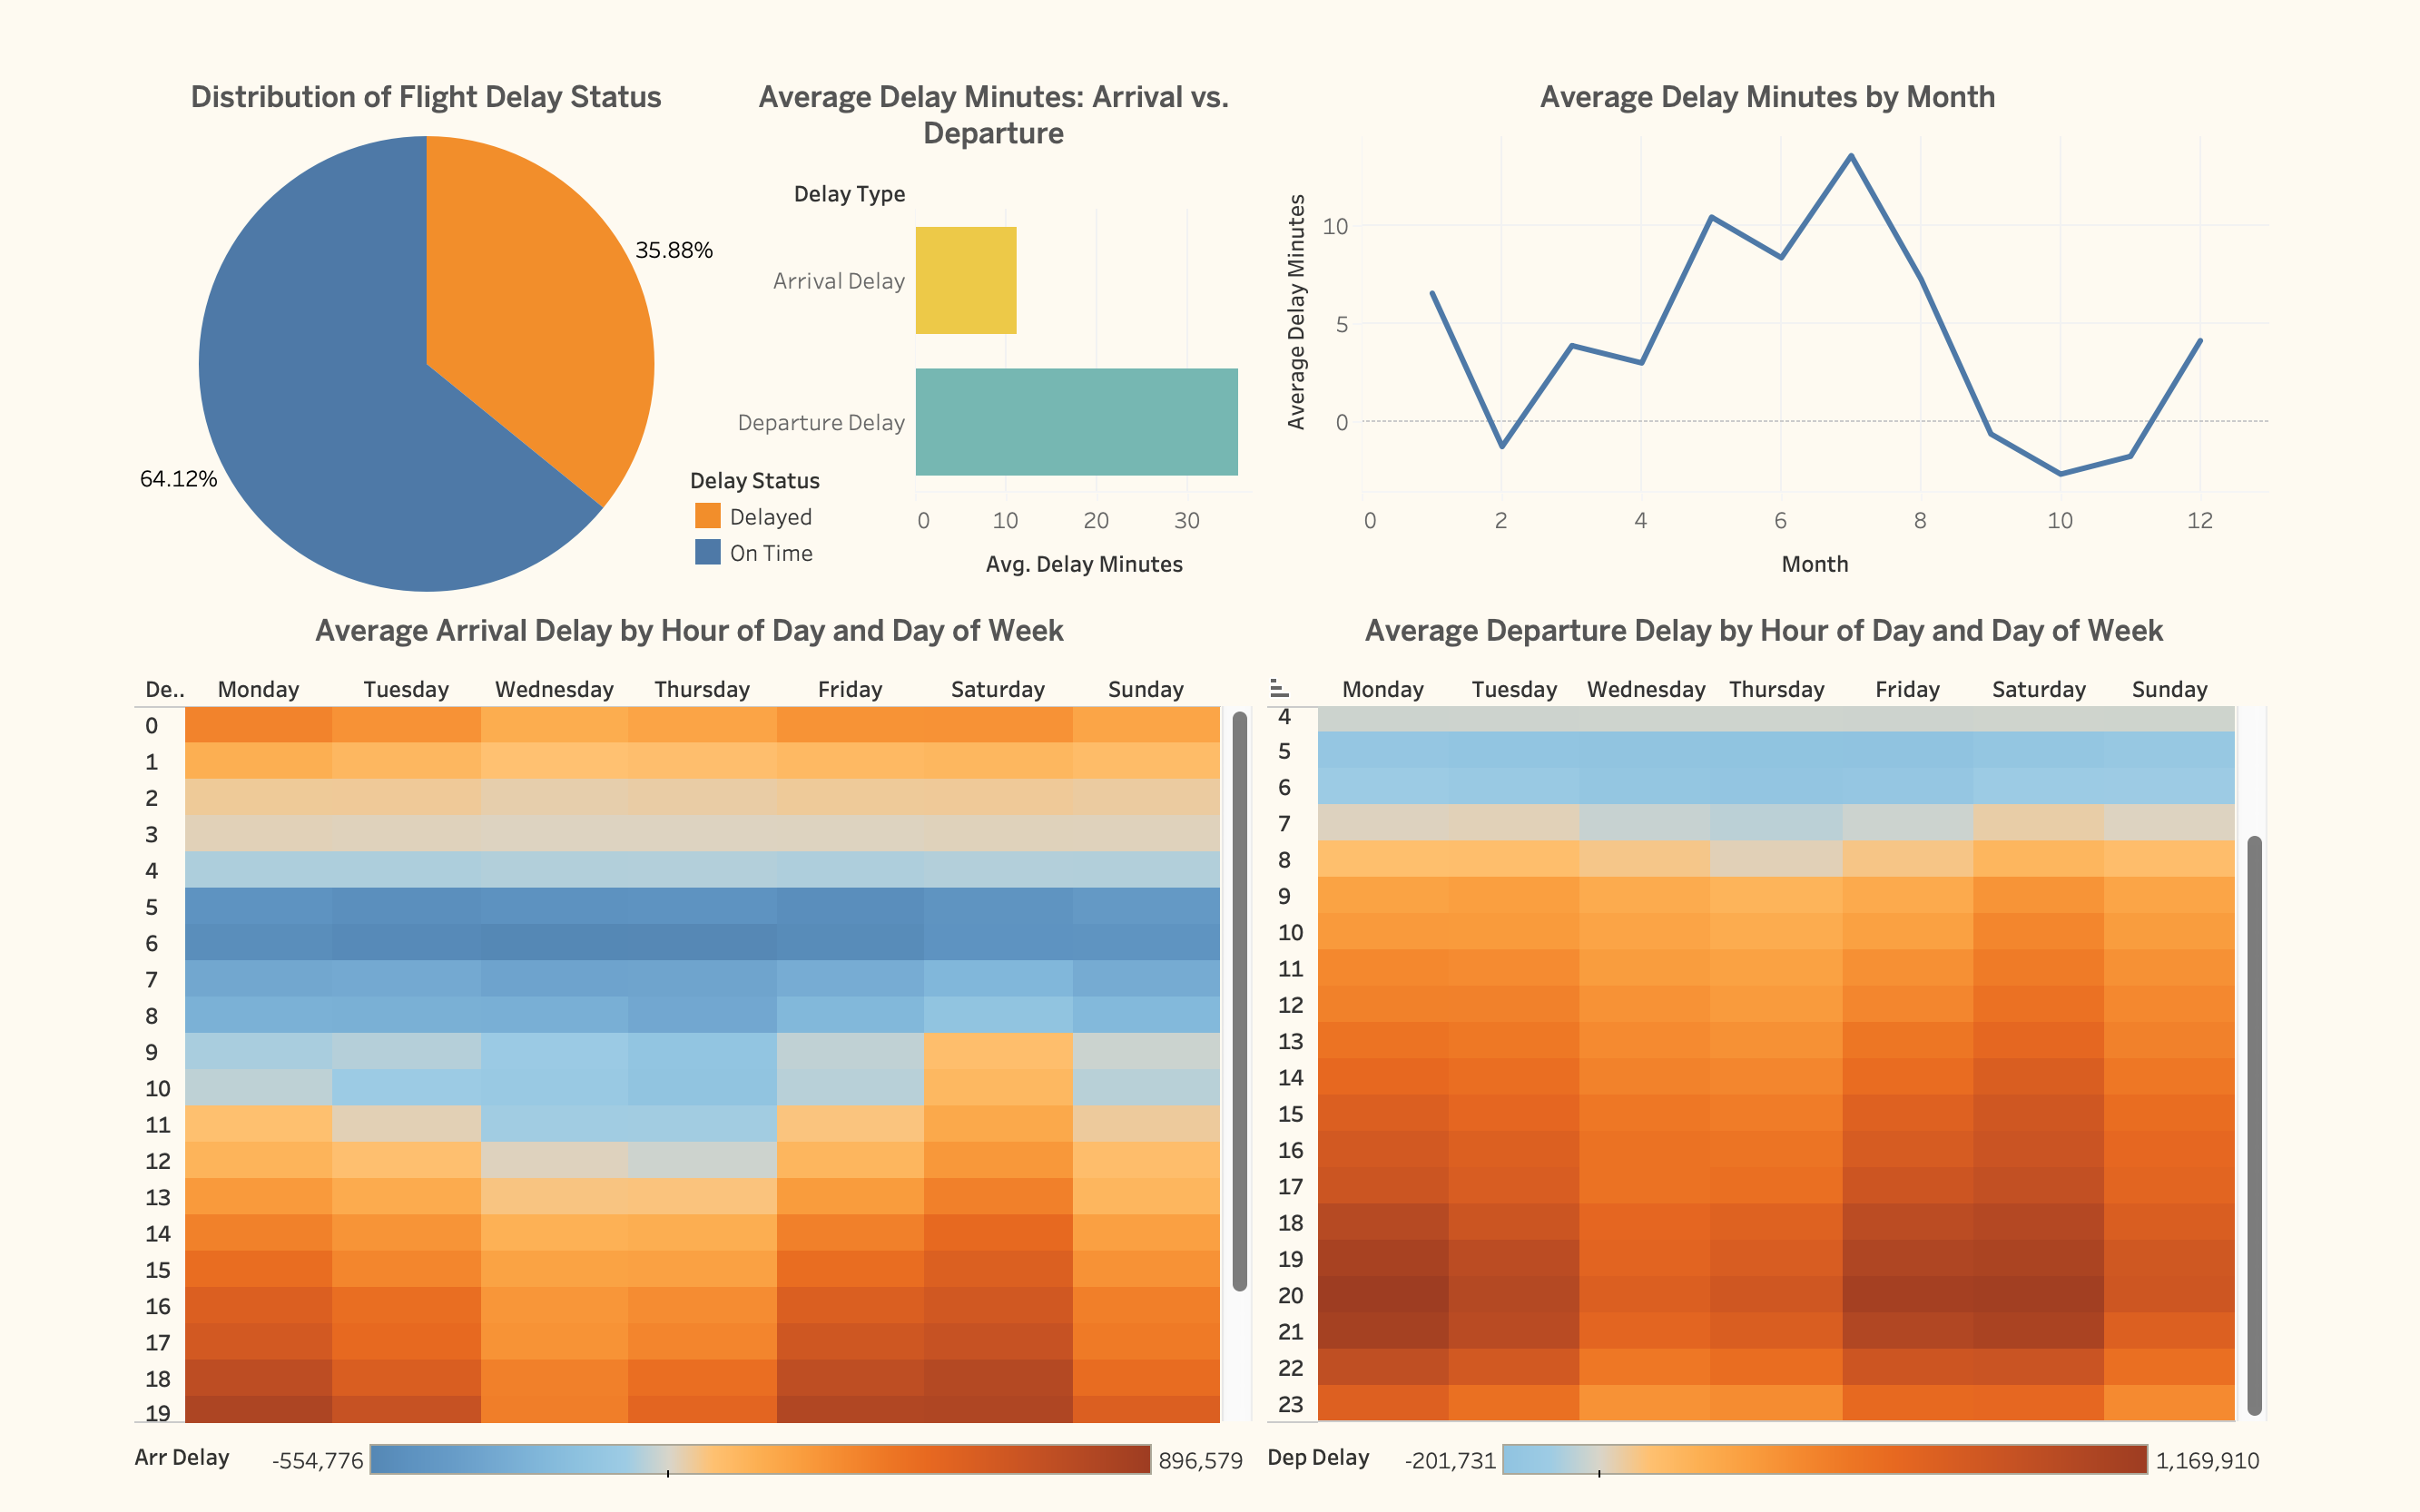

**Dashboard 2** shows that delays are concentrated in regional airports and heavily traveled corridors. Operational factors (late aircraft and carrier delays) dominate the cause breakdown, while weather contributes minimally. A small number of high-traffic routes and airports account for a disproportionate share of overall disruptions, emphasizing the need for improved scheduling resilience and resource allocation.
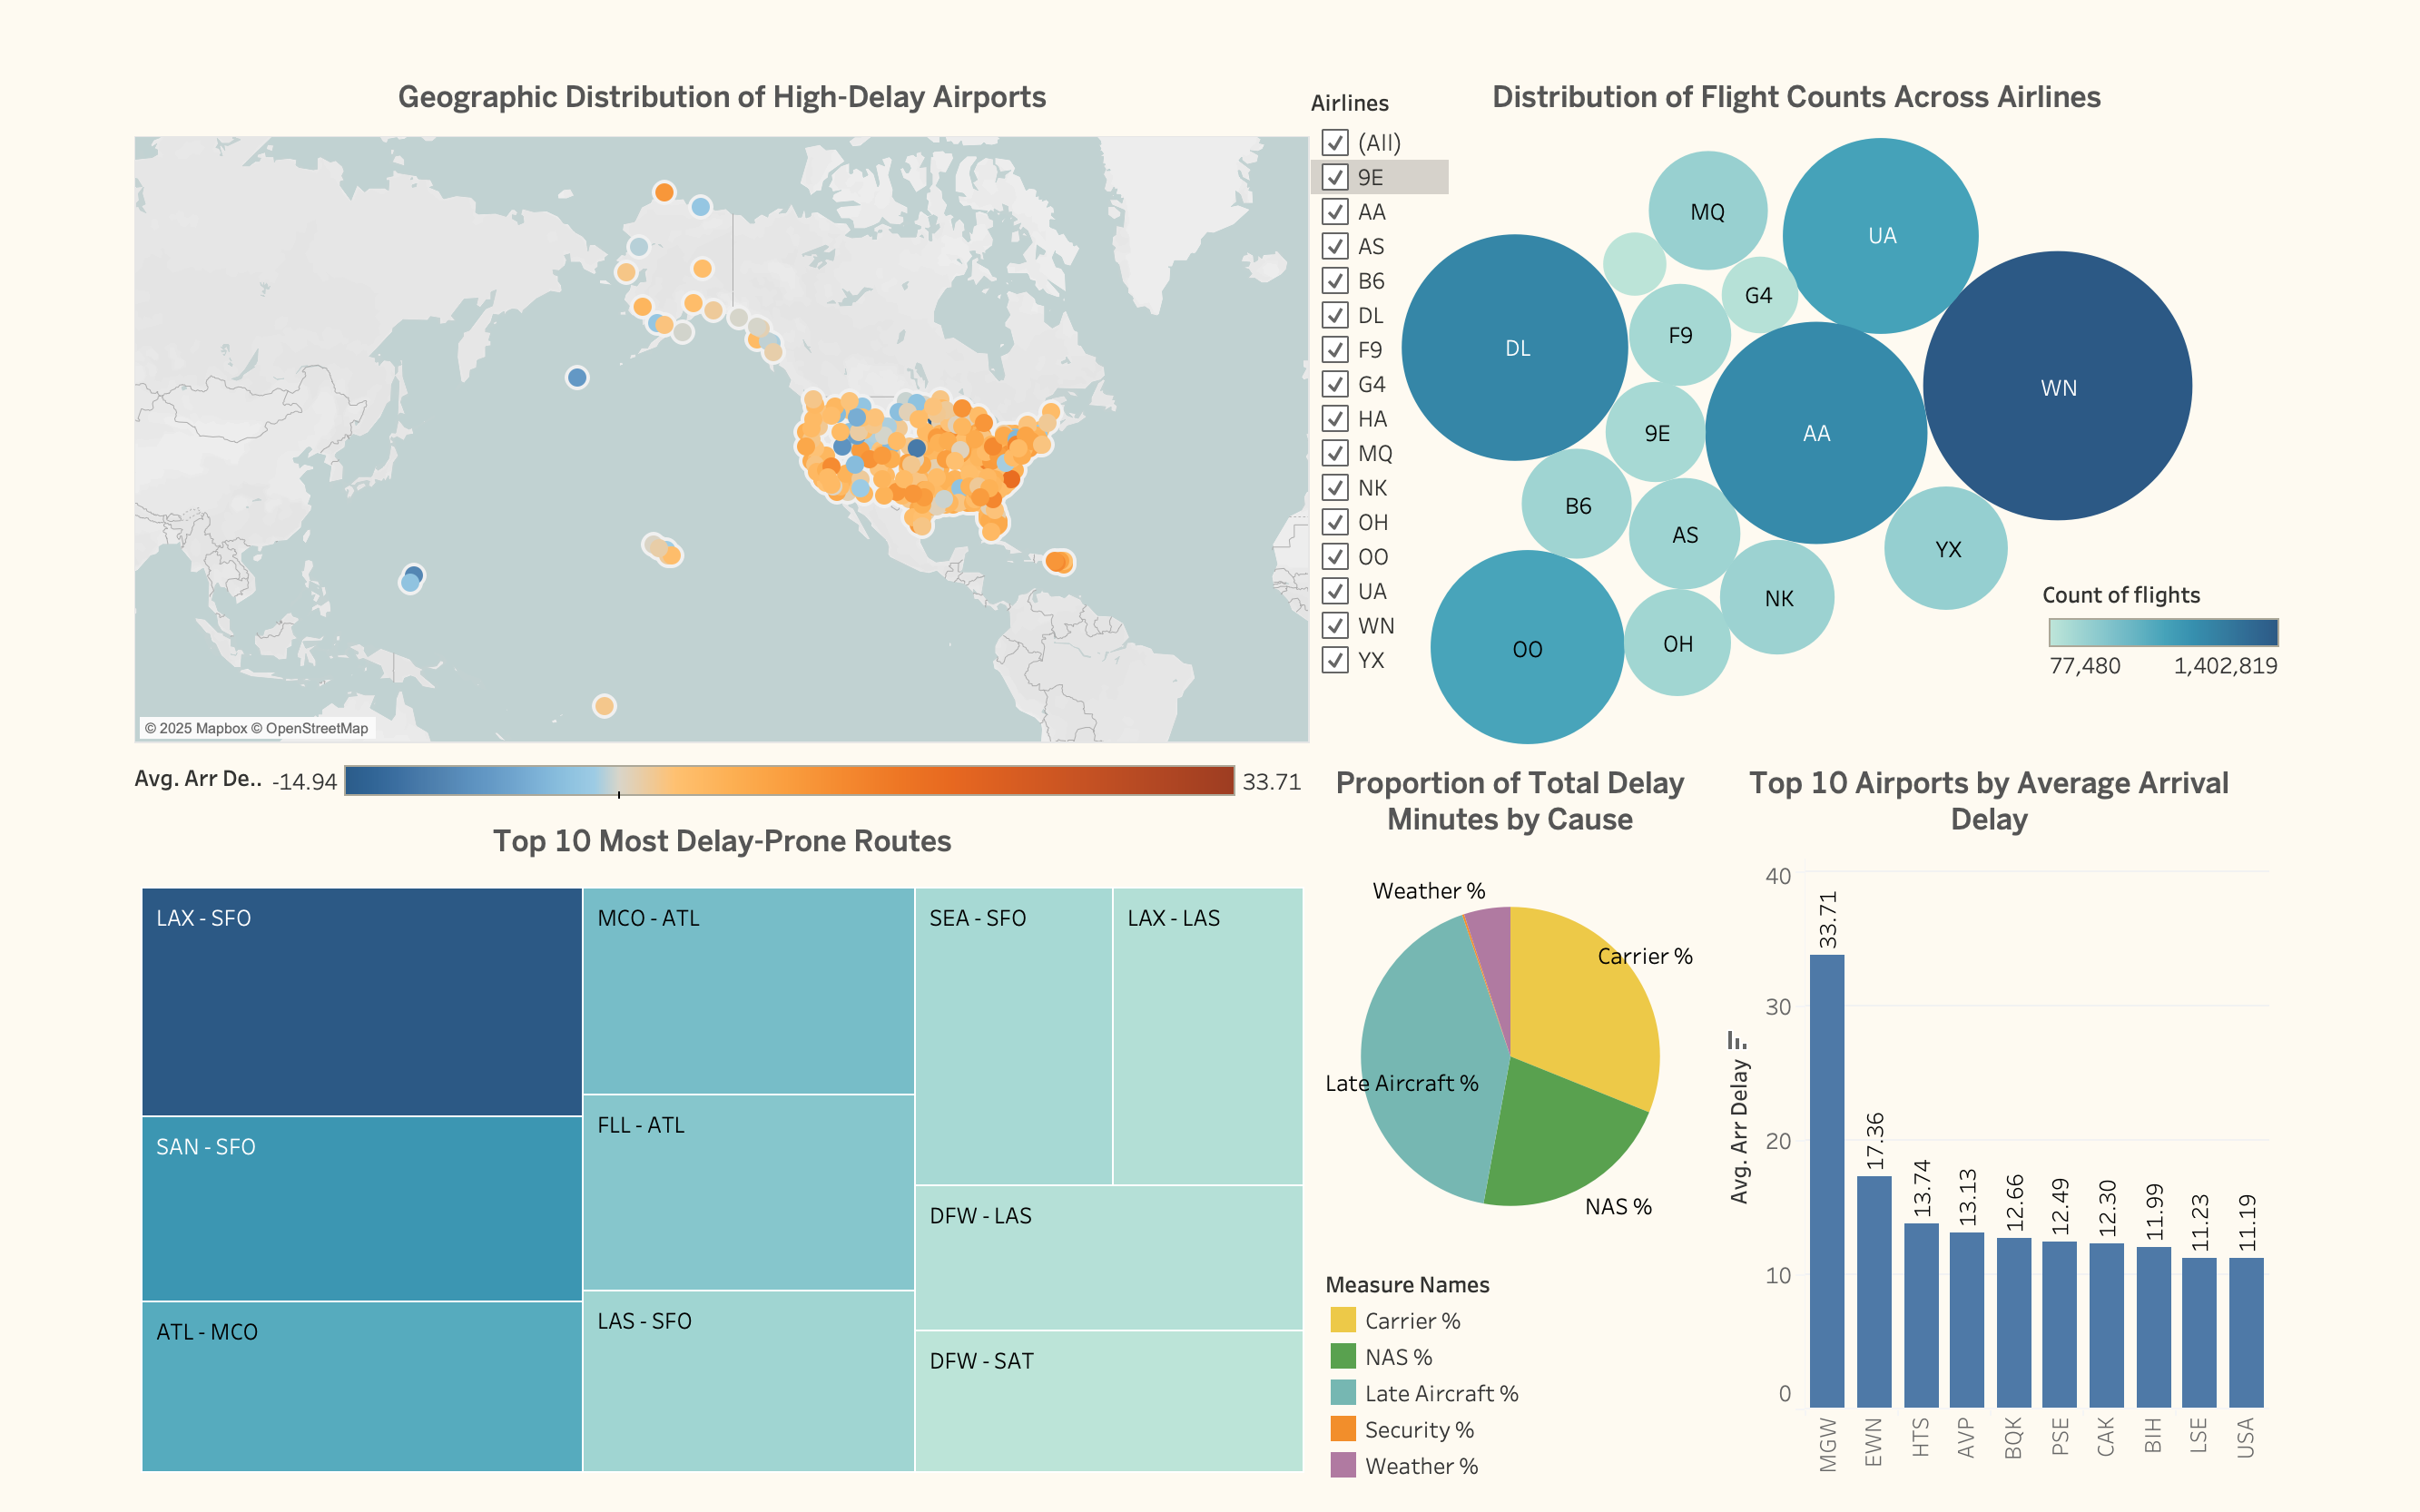

#**Introduction & Motivation**

Flight delays are more than a minor inconvenience—they shape how passengers experience air travel, how airlines design their schedules, and how airports manage scarce runway and gate capacity. In 2024 alone, the U.S. system recorded over 7 million domestic flights with detailed information on timing, delay minutes, and cause-level breakdowns, offering a rare, system-wide view of where and why disruptions occur. Yet this scale also makes delays difficult to understand intuitively: it is hard for decision-makers to see whether delays are getting better or worse, which carriers or airports are driving the problem, and whether issues are due to weather, airspace congestion, or internal airline operations.

This analysis, Mapping the Skies, aims to turn that raw data into an interpretable story about U.S. flight punctuality in 2024. Using a cleaned and standardized BigQuery table built from the Kaggle dataset, we examine delays across five complementary dimensions: overall delay levels, temporal and seasonal patterns, airline and airport performance, delay causes, and route and distance effects. Readers should care about this work because it moves beyond isolated anecdotes (“my flight was delayed”) and provides evidence-based answers to practical questions: When are delays most likely to occur? Which airlines and airports are most exposed? Are delays mainly caused by weather or by controllable operational factors? By distilling more than thirteen million records into a set of focused, business-relevant insights, this project helps airlines, airports, regulators, and even frequent flyers understand where targeted interventions could meaningfully improve on-time performance.

#**Entity Relationship Diagram**
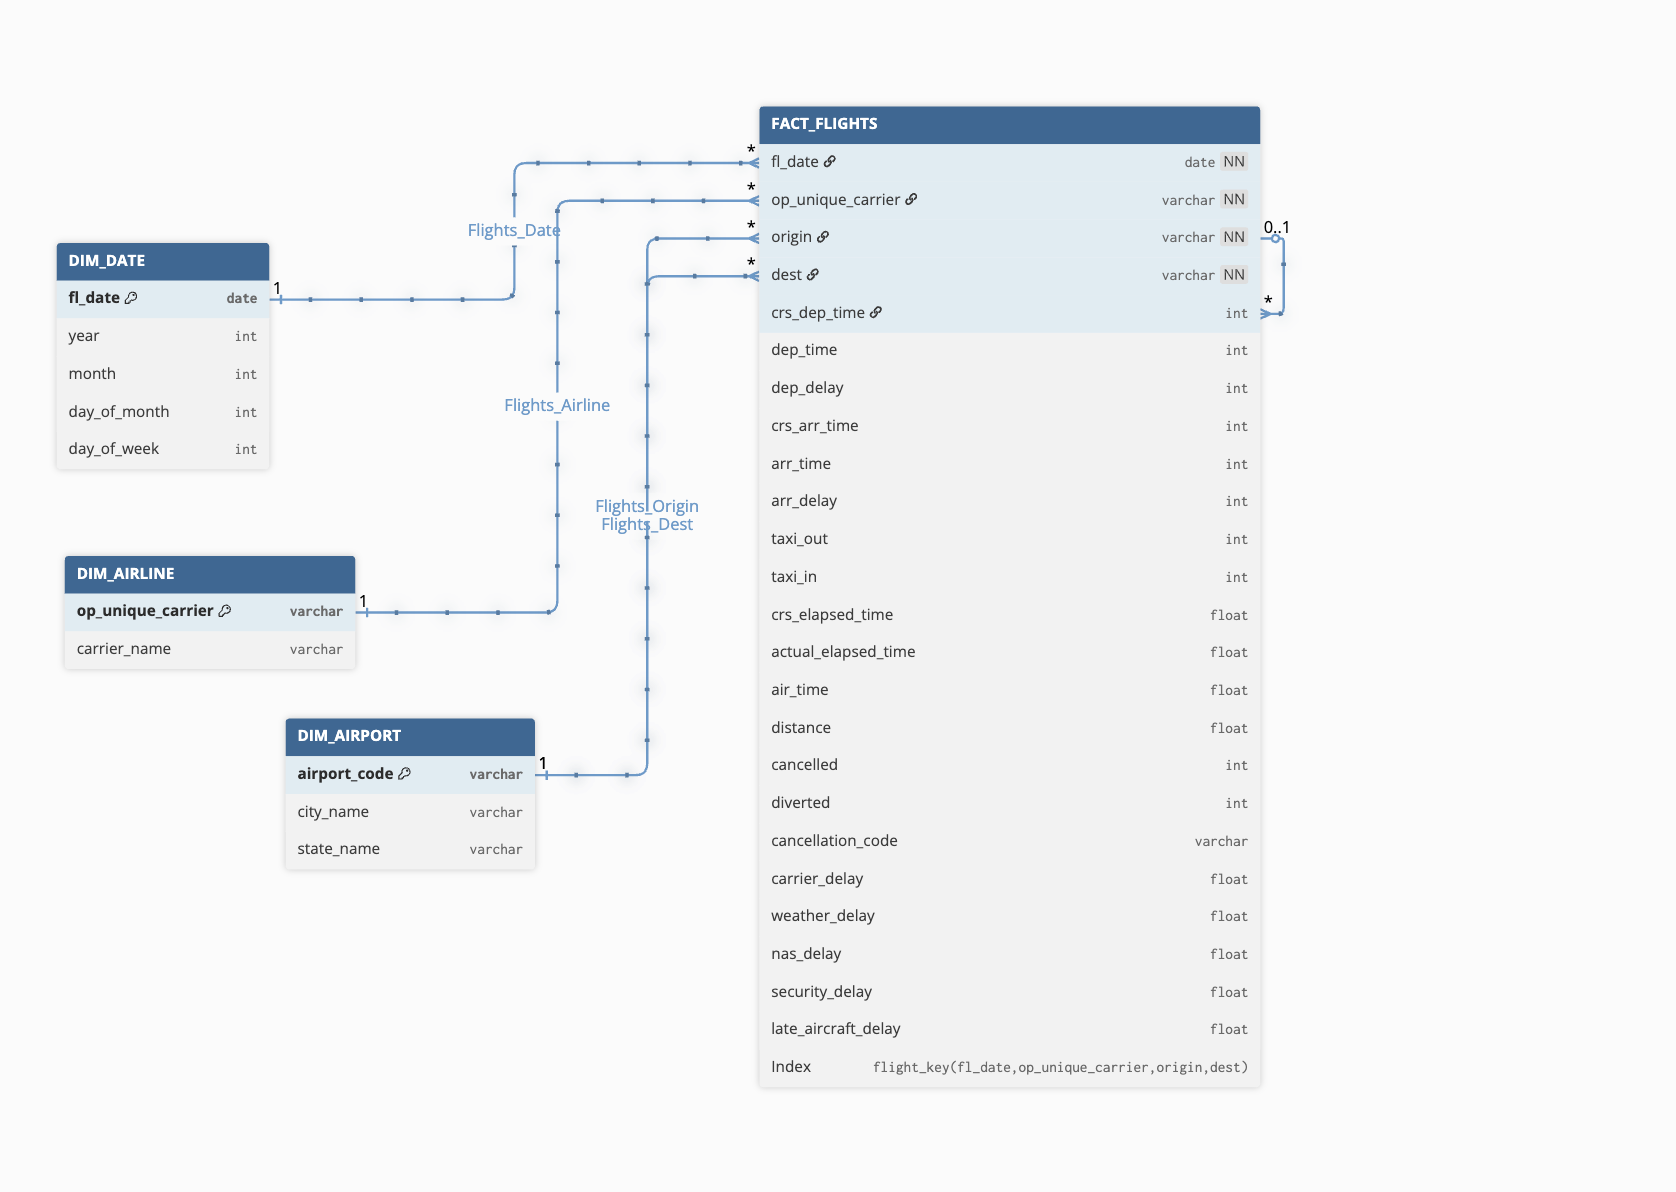

#**Problem Definition**
Flight delays are a persistent challenge in the U.S. air transportation system, affecting millions of passengers, disrupting airline operations, and straining airport capacity.
Understanding when, where, and why delays occur is essential for several key stakeholders:

* Airlines - who must optimize schedules, improve turnaround times, and reduce operational costs

* Airports - who need to manage congestion, runway capacity, and gate allocation

* Regulators (FAA) - who monitor national airspace performance and implement delay-reduction policies

* Passengers - who experience the direct impact of delays through missed connections and travel disruptions

This analysis examines 2024 flight performance across six analytical dimensions:
1. **Overall Delay Overview** – Frequency and severity of delays
2. **Temporal & Seasonal Trends** – Variation across months and times of day
3. **Airline & Airport Performance** – Differences across carriers and hubs
4. **Delay Causes Breakdown** – Relative impact of each delay type
5. **Route & Distance Patterns** – Short- vs. long-haul reliability
6. **Extreme Delay Events & Window Function Insights%** – Short- vs. long-haul reliability

By structuring the analysis across these dimensions, this study provides actionable insights for operational planning, resource allocation, and service improvement.
Ultimately, the findings help airlines, airports, and policymakers target delay-reduction strategies that improve efficiency and enhance passenger experience.

#**Data Description**
 This project uses large U.S. domestic flight datasets: a 7.07 million–row 2024 dataset compiled on Kaggle .Datasets include detailed flight schedules, delays, cancellation indicators, and cause-level delay breakdowns.
Analyzing flight delays is important because they directly affect traveler experience, airline operational efficiency, airport congestion, and overall transportation system reliability. Understanding where, when, and why delays occur helps airlines and airports make evidence-based decisions that reduce disruptions and improve on-time performance.

##Data Types of Every Column

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  column_name,
  data_type,
  is_nullable
FROM `ba775-ply.775teamdata`.INFORMATION_SCHEMA.COLUMNS
WHERE table_name = '775table'
ORDER BY column_name;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=35, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

##Check total number of rows

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT COUNT(*) AS total_rows
FROM `ba775-ply.775teamdata.775table`;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

##Show all column names

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT column_name
FROM `ba775-ply.775teamdata`.INFORMATION_SCHEMA.COLUMNS
WHERE table_name = '775table';


""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=35, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

#**Data Cleaning**
The dataset was cleaned to remove missing or invalid records, standardize field formats, and normalize delay causes.

Steps:
- Removed flights missing date, carrier, or airport codes  
- Filtered out extreme delays (|arr_delay| > 300 minutes)  
- Converted all numeric fields to proper numeric types  
- Replaced NULL delay causes with 0  
- Converted carrier and airport codes to uppercase  
- Dropped redundant and low-value columns (city/state names, flight number, wheels_off/on) to simplify analysis


In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-ply.775teamdata.flights_cleaned_step1` AS
SELECT
  -- Core temporal columns
  SAFE_CAST(year AS INT64) AS year,
  SAFE_CAST(month AS INT64) AS month,
  SAFE_CAST(day_of_month AS INT64) AS day_of_month,
  SAFE_CAST(day_of_week AS INT64) AS day_of_week,
  CAST(fl_date AS DATE) AS fl_date,

  -- Airline + airport identifiers
  UPPER(TRIM(op_unique_carrier)) AS op_unique_carrier,
  UPPER(TRIM(origin)) AS origin,
  UPPER(TRIM(dest)) AS dest,

  -- Flight scheduling and timing
  SAFE_CAST(crs_dep_time AS INT64) AS crs_dep_time,
  SAFE_CAST(dep_time AS INT64) AS dep_time,
  SAFE_CAST(dep_delay AS INT64) AS dep_delay,
  SAFE_CAST(taxi_out AS INT64) AS taxi_out,
  SAFE_CAST(taxi_in AS INT64) AS taxi_in,
  SAFE_CAST(crs_arr_time AS INT64) AS crs_arr_time,
  SAFE_CAST(arr_time AS INT64) AS arr_time,
  SAFE_CAST(arr_delay AS INT64) AS arr_delay,

  -- Operational metrics
  SAFE_CAST(cancelled AS INT64) AS cancelled,
  SAFE_CAST(diverted AS INT64) AS diverted,
  SAFE_CAST(crs_elapsed_time AS FLOAT64) AS crs_elapsed_time,
  SAFE_CAST(actual_elapsed_time AS FLOAT64) AS actual_elapsed_time,
  SAFE_CAST(air_time AS FLOAT64) AS air_time,
  SAFE_CAST(distance AS FLOAT64) AS distance,

  -- Delay causes (replace NULLs with 0)
  COALESCE(carrier_delay, 0) AS carrier_delay,
  COALESCE(weather_delay, 0) AS weather_delay,
  COALESCE(nas_delay, 0) AS nas_delay,
  COALESCE(security_delay, 0) AS security_delay,
  COALESCE(late_aircraft_delay, 0) AS late_aircraft_delay

FROM
  `ba775-ply.775teamdata.775table`
WHERE
  fl_date IS NOT NULL
  AND op_unique_carrier IS NOT NULL
  AND origin IS NOT NULL
  AND dest IS NOT NULL
  AND arr_delay BETWEEN -300 AND 300
  AND dep_delay BETWEEN -300 AND 300;


""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT column_name
FROM `ba775-ply.775teamdata.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'flights_cleaned_step1';

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=27, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT *
FROM `ba775-ply.775teamdata.flights_cleaned_step1`
LIMIT 10;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=10, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

#**Verification**
The cleaned dataset retains nearly all valid flights while removing incomplete or extreme records.  
Data preview confirms that numeric fields are properly formatted, missing delay causes are zero-filled, and redundant columns have been dropped.  
The final table (`flights_cleaned_step1`) is now ready for SQL analysis in the following sections.


In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  (SELECT COUNT(*)
   FROM `ba775-ply.775teamdata`.INFORMATION_SCHEMA.COLUMNS
   WHERE table_name = '775table') AS columns_before_cleaning,

  (SELECT COUNT(*)
   FROM `ba775-ply.775teamdata`.INFORMATION_SCHEMA.COLUMNS
   WHERE table_name = 'flights_cleaned_step1') AS columns_after_cleaning;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  (SELECT COUNT(*) FROM `ba775-ply.775teamdata.775table`) AS before_cleaning,
  (SELECT COUNT(*) FROM `ba775-ply.775teamdata.flights_cleaned_step1`) AS after_cleaning;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

#**Exploratory Data Analysis (EDA)**

Now that we have a clean and standardized flight dataset (`flights_cleaned_step1`), we can begin our analysis.  
The following sections use pure SQL queries in BigQuery to explore flight delay trends across multiple dimensions — including overall delay statistics, temporal patterns, airline performance, delay causes, and route-level variations.


#**Section 1. Overall Delay Overview**
#### **Q1-A.** In 2024, what percentage of flights were delayed, and what was the average delay time?


In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
 COUNTIF(arr_delay > 0) / COUNT(*) * 100 AS pct_flights_delayed,
 AVG(arr_delay) AS avg_arrival_delay_minutes
FROM `ba775-ply.775teamdata.flights_cleaned_step1`
WHERE EXTRACT(YEAR FROM fl_date) = 2024;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

**A1-A:**  
Approximately 36% of flights in 2024 were delayed, but the average delay was modest (~4 minutes).  
This suggests that while minor delays are common, severe disruptions were relatively rare.


**Q1-B.** Among flights that were delayed in 2024, what was the average delay duration?

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
 AVG(arr_delay) AS avg_delay_only_delayed_flights
FROM `ba775-ply.775teamdata.flights_cleaned_step1`
WHERE EXTRACT(YEAR FROM fl_date) = 2024
 AND arr_delay > 0;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

**A1-B**. Among flights that experienced an arrival delay in 2024, the average delay duration was approximately 37 minutes. This indicates that although not all flights were delayed, the delays that did occur tended to be substantial in length rather than minor schedule shifts. A delay of around 37 minutes is long enough to affect passenger experience, connection timing, and downstream scheduling operations. This suggests that while airlines may be maintaining reasonable overall punctuality at the system level, delay events themselves carry a noticeable operational and passenger impact once they occur.

**Q2.** Among arrival delay and departure delay in 2024, which one was generally more severe?

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
AVG(dep_delay) AS avg_departure_delay_only_delayed,
AVG(arr_delay) AS avg_arrival_delay_only_delayed
FROM `ba775-ply.775teamdata.flights_cleaned_step1`
WHERE EXTRACT(YEAR FROM fl_date) = 2024
 AND (dep_delay > 0 OR arr_delay > 0);

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

**A.2** In 2024, flights that experienced delays showed an average departure delay of approximately 27.9 minutes, compared to an average arrival delay of about 26.9 minutes. This indicates that departure delays were slightly more severe than arrival delays. The smaller delay observed upon arrival suggests that airlines may have been able to recover part of the delay during the flight, likely through adjustments in cruising speed or optimized routing. Overall, the results imply that while delays often originated at departure, operational adjustments helped mitigate their impact by the time the aircraft reached its destination.

##*Mini Conclusion (Section 1)*
Overall, about one-third of flights in 2024 were delayed, and delays tended to be moderate in length. Departure delays were slightly more severe than arrival delays, suggesting airlines attempt to recover lost time during flights. These results indicate that delays are common but generally manageable at the national level.


#**Section 2: Temporal & Seasonal Trends**


**Q3.** Which months in 2024 experienced the highest average delay minutes and total delay minutes, and what seasonal patterns can be observed?

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
 EXTRACT(MONTH FROM fl_date) AS month,
 AVG(arr_delay) AS avg_arrival_delay_minutes,
 SUM(arr_delay) AS total_arrival_delay_minutes
FROM `ba775-ply.775teamdata.flights_cleaned_step1`
WHERE EXTRACT(YEAR FROM fl_date) = 2024
GROUP BY month
ORDER BY avg_arrival_delay_minutes DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=12, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

**A.3**: In 2024, flight delays exhibited a clear seasonal trend. July recorded both the highest average delay and the highest total delay minutes, making it the most disruption-heavy month of the year. The months of May, June, and August also experienced elevated delay levels, reflecting the impact of the summer travel peak, where increased passenger volume and weather-related disruptions intensify operational congestion.
In contrast, February, September, October, and November showed minimal or even slightly negative average delay minutes, indicating smoother flight operations during these off-peak periods. This suggests that flight delays are strongly seasonal, with major delay events concentrated in summer, while late winter and early fall demonstrate more efficient and on-time performance.


**Q4.** How do delay durations vary across different times of day in 2024 (morning vs. afternoon vs. evening)?

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH base AS (
 SELECT
   CASE
     WHEN dep_time = 2400 THEN 0
     WHEN dep_time IS NULL THEN NULL
     ELSE CAST(FLOOR(dep_time / 100) AS INT64)
   END AS dep_hour,
   arr_delay,
   dep_delay
 FROM `ba775-ply.775teamdata.flights_cleaned_step1`
 WHERE EXTRACT(YEAR FROM fl_date) = 2024
),
time_buckets AS (
 SELECT
   CASE
     WHEN dep_hour BETWEEN 5 AND 11 THEN 'Morning (05:00–11:59)'
     WHEN dep_hour BETWEEN 12 AND 17 THEN 'Afternoon (12:00–17:59)'
     ELSE 'Evening/Night (18:00–04:59)'
   END AS time_of_day,
   arr_delay,
   dep_delay
 FROM base
)
SELECT
 time_of_day,
 COUNT(*) AS num_flights,
 ROUND(AVG(arr_delay), 2) AS avg_arrival_delay_all_flights,
 ROUND(AVG(IF(arr_delay > 0, arr_delay, NULL)), 2) AS avg_arrival_delay_delayed_flights,
 ROUND(AVG(dep_delay), 2) AS avg_departure_delay_all_flights,
 ROUND(AVG(IF(dep_delay > 0, dep_delay, NULL)), 2) AS avg_departure_delay_delayed_flights
FROM time_buckets
GROUP BY time_of_day
ORDER BY avg_arrival_delay_all_flights DESC;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=3, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

**A.4:**  
Flight delays in 2024 show a strong time-of-day pattern.  
- **Evening and night flights (18:00–04:59)** experienced the most severe delays, with an average **arrival delay of 16.6 minutes** across all flights and **49.2 minutes** among only delayed flights. Departure delays were even higher (22.1 minutes on average), suggesting that schedule disruptions accumulate as the day progresses.  
- **Afternoon flights (12:00–17:59)** had moderate delays, averaging **5.5 minutes** for arrivals and **10.5 minutes** for departures, reflecting rising traffic and congestion during midday operations.  
- **Morning flights (05:00–11:59)** were generally on time or slightly early, with an average **arrival delay of –4.0 minutes**, meaning most morning flights departed and arrived punctually before systemic delays began to build up.  

These results highlight a clear **delay propagation effect** — minor disruptions early in the day compound into larger evening delays as aircraft, crews, and gates rotate through multiple trips.  
Operationally, this suggests that **scheduling buffers or improved turnaround efficiency in early flights** could help reduce cumulative evening congestion.


##*Mini Conclusion (Section 2)*
Delays followed strong seasonal and time-of-day patterns. Summer months experienced the worst delays due to high traffic and weather. Morning flights were the most on-time, while delays accumulated through the day and peaked at night. This shows clear structural and operational patterns that repeat daily and annually.

#**Section 3 : Airline & Airport Performance**
**Q5.** Which airlines had the longest average arrival delays in 2024, and how does performance differ across major carriers?

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
 op_unique_carrier AS airline,
 COUNT(*) AS num_flights,
 ROUND(AVG(arr_delay), 2) AS avg_arrival_delay
FROM `ba775-ply.775teamdata.flights_cleaned_step1`
WHERE
 cancelled = 0
 AND arr_delay IS NOT NULL
GROUP BY op_unique_carrier
ORDER BY avg_arrival_delay DESC
LIMIT 1;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH major_carriers AS (
 SELECT
   op_unique_carrier,
   COUNT(*) AS total_flights
 FROM `ba775-ply.775teamdata.flights_cleaned_step1`
 GROUP BY op_unique_carrier
 ORDER BY total_flights DESC
 LIMIT 5
)
SELECT
 f.op_unique_carrier AS airline,
 COUNT(*) AS total_flights,
 ROUND(SUM(CASE WHEN f.cancelled = 1 THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS cancellation_rate_percent,
 ROUND(AVG(f.arr_delay), 2) AS avg_arrival_delay_minutes
FROM `ba775-ply.775teamdata.flights_cleaned_step1` f
JOIN major_carriers mc
 ON f.op_unique_carrier = mc.op_unique_carrier
WHERE f.arr_delay IS NOT NULL
GROUP BY f.op_unique_carrier
ORDER BY avg_arrival_delay_minutes DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=5, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

**A.5:**  
Frontier Airlines (F9) recorded the highest average arrival delay of **10.3 minutes** in 2024, higher than any of the five largest U.S. carriers. This reflects its ultra–low-cost operating model, which emphasizes quick aircraft turnaround and minimal schedule padding. While this improves efficiency under normal conditions, it leaves little flexibility when disruptions occur, causing small delays to propagate more easily across flights.  

Among the major carriers, **American Airlines (AA)** showed the highest average arrival delay (**9.0 minutes**), while **Delta Air Lines (DL)** achieved the best on-time performance with only **1.0 minute** of average delay.  
All major carriers had **a 0% cancellation rate**, highlighting strong reliability but variable schedule discipline.  
Overall, the findings suggest that **operational strategy, hub congestion, and turnaround efficiency** are key factors driving airline-level delay differences.


 **Q6.** Which airports recorded the highest average delay minutes in 2024? Are these delays concentrated in certain regions or airport types (e.g., hubs vs. non-hubs)?



In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
 dest AS airport,
 COUNT(*) AS num_arrivals,
 ROUND(AVG(arr_delay), 2) AS avg_arrival_delay_minutes
FROM `ba775-ply.775teamdata.flights_cleaned_step1`
WHERE
 cancelled = 0
 AND arr_delay IS NOT NULL
 AND EXTRACT(YEAR FROM fl_date) = 2024
GROUP BY dest
ORDER BY avg_arrival_delay_minutes DESC
LIMIT 1;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
 dest AS airport,
 COUNT(*) AS num_arrivals,
 ROUND(AVG(arr_delay), 2) AS avg_arrival_delay_minutes
FROM `ba775-ply.775teamdata.flights_cleaned_step1`
WHERE
 cancelled = 0
 AND arr_delay IS NOT NULL
 AND EXTRACT(YEAR FROM fl_date) = 2024
GROUP BY dest
ORDER BY avg_arrival_delay_minutes DESC
LIMIT 10;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=10, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

**A.6**  
In 2024, the airports with the highest average arrival delays were primarily **small regional or non-hub airports**, not major airline hubs.  
**Morgantown (MGW)** had the longest average delay, at **33.7 minutes**, followed by **New Bern (EWN)** at **17.4 minutes** and **Huntington (HTS)** at **13.7 minutes**.  
These airports handle relatively low volumes of traffic (under 2,000 annual arrivals), indicating that delays are more pronounced in smaller regional airports rather than large, congested hubs.  

This pattern suggests that **regional operations are more vulnerable** to delays caused by limited ground infrastructure, weather disruptions, and dependence on connecting feeder flights.  
In contrast, large hub airports—despite higher traffic—benefit from **better scheduling resilience, multiple runways, and stronger resource management**, leading to lower average delays.  

Overall, the results reveal that in 2024, **delays were concentrated in non-hub and regional airports**, emphasizing how smaller airports can face disproportionately longer disruptions due to limited operational capacity.




##*Mini Conclusion (Section 3)*
Overall, airline performance in 2024 showed clear differences driven by operational strategy and network structure. Frontier (F9) had the highest average delays among major carriers, reflecting the limited schedule padding typical of ultra–low-cost models, while Delta (DL) remained the most punctual. At the airport level, the longest average delays were concentrated in small regional airports rather than large hubs, indicating that limited infrastructure, weather sensitivity, and reliance on feeder connections make regional airports more vulnerable to disruptions. Together, these results highlight that both airline operating models and airport scale/capacity play key roles in shaping delay patterns across the U.S. system.

#**Section 4 : Delay Causes Breakdown**
**Q7.** What percentage of total delay minutes in 2024 was caused by each category:

* Carrier Delay


* Weather Delay


* NAS (National Airspace System) Delay


* Security Delay


* Late Aircraft Delay







In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
 ROUND(SUM(carrier_delay) / SUM(
     carrier_delay + weather_delay + nas_delay + security_delay + late_aircraft_delay
 ) * 100, 2) AS carrier_delay_pct,
 ROUND(SUM(weather_delay) / SUM(
     carrier_delay + weather_delay + nas_delay + security_delay + late_aircraft_delay
 ) * 100, 2) AS weather_delay_pct,
 ROUND(SUM(nas_delay) / SUM(
     carrier_delay + weather_delay + nas_delay + security_delay + late_aircraft_delay
 ) * 100, 2) AS nas_delay_pct,
 ROUND(SUM(security_delay) / SUM(
     carrier_delay + weather_delay + nas_delay + security_delay + late_aircraft_delay
 ) * 100, 2) AS security_delay_pct,
 ROUND(SUM(late_aircraft_delay) / SUM(
     carrier_delay + weather_delay + nas_delay + security_delay + late_aircraft_delay
 ) * 100, 2) AS late_aircraft_delay_pct
FROM
 `ba775-ply.775teamdata.flights_cleaned_step1`;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

**A.7:**  
In 2024, the majority of total delay minutes were caused by **Late Aircraft Delays (41.9%)** and **Carrier Delays (31.1%)**, together accounting for over **70%** of all delay time across U.S. flights.  
This indicates that most disruptions originated from **airline operational issues** (such as late inbound aircraft, crew rotations, or maintenance) rather than external factors.  

**NAS (National Airspace System) Delays** contributed **21.8%**, reflecting the impact of air traffic control congestion and route capacity limitations.  
**Weather Delays** accounted for only **5.0%**, showing that while weather events can be severe, they are relatively infrequent compared to carrier-driven or system-driven delays.  
**Security Delays** were negligible at **0.2%**, having minimal influence on overall punctuality.  

Overall, the findings emphasize that **internal airline operations and network dependencies**—not external conditions—are the leading drivers of flight delays.  
Reducing aircraft turnaround bottlenecks and improving schedule recovery could significantly improve overall on-time performance.


**Q8.** Which delay type contributed the highest frequency proportion in 2024?

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH delay_counts AS (
 SELECT
   COUNTIF(carrier_delay > 0) AS carrier_delay_count,
   COUNTIF(weather_delay > 0) AS weather_delay_count,
   COUNTIF(nas_delay > 0) AS nas_delay_count,
   COUNTIF(security_delay > 0) AS security_delay_count,
   COUNTIF(late_aircraft_delay > 0) AS late_aircraft_delay_count
 FROM
   `ba775-ply.775teamdata.flights_cleaned_step1`
)
SELECT
 ROUND(carrier_delay_count * 100.0 / total, 2) AS carrier_delay_pct,
 ROUND(weather_delay_count * 100.0 / total, 2) AS weather_delay_pct,
 ROUND(nas_delay_count * 100.0 / total, 2) AS nas_delay_pct,
 ROUND(security_delay_count * 100.0 / total, 2) AS security_delay_pct,
 ROUND(late_aircraft_delay_count * 100.0 / total, 2) AS late_aircraft_delay_pct
FROM (
 SELECT
   *,
   (carrier_delay_count + weather_delay_count + nas_delay_count + security_delay_count + late_aircraft_delay_count) AS total
 FROM delay_counts
);

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

**A.8**  
In 2024, the most frequent cause of delays was **Carrier Delay**, accounting for **33.4%** of all delayed flights, followed closely by **Late Aircraft Delays (31.6%)** and **NAS Delays (31.1%)**.  
This shows that airline-related operational issues continue to dominate both in **how often** delays occur and **how long** they last.  

While weather accounted for only **3.7%** of delay occurrences, and security for just **0.3%**, their impact remains minor compared to airline-driven and airspace-related disruptions.  
These results mirror the findings from total delay time (Q7), reinforcing that **most flight delays originate within the airline system itself**—either due to aircraft arriving late from previous routes or carrier-level scheduling and ground handling inefficiencies.  

Together, **Carrier**, **Late Aircraft**, and **NAS delays** made up nearly **96%** of all delay incidents in 2024, suggesting that targeted improvements in airline turnaround management and air traffic coordination could substantially enhance punctuality.


##*Mini Conclusion ( Section 4)*
Flight delays in 2024 were overwhelmingly driven by airline-controlled factors: Late Aircraft and Carrier delays accounted for more than 70% of total delay minutes and over 65% of all delay occurrences. NAS delays also played a significant role, contributing around one-fifth of delay time and one-third of delay events, while weather and security disruptions were comparatively rare. Overall, the results show that most delays stem from internal airline operations and network dependencies rather than external conditions, highlighting the need for improved aircraft turnaround efficiency and better coordination across the air traffic system.

#**Section 5: Route & Distance Patterns**
**Q9.** In 2024, do long-haul flights (distance > 1500 miles) generally have greater or fewer delays than short-haul flights?


In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
 CASE
   WHEN distance > 1500 THEN 'Long-haul'
   ELSE 'Short-haul'
 END AS flight_type,
 AVG(dep_delay) AS avg_departure_delay
FROM `ba775-ply.775teamdata.flights_cleaned_step1`
GROUP BY flight_type;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=2, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

**A.9**  
In 2024, **long-haul flights (distance > 1,500 miles)** recorded a slightly higher average departure delay (**10.4 minutes**) compared to **short-haul flights (9.8 minutes)**.  
While the difference is modest, it suggests that longer routes tend to experience marginally greater departure delays.  

This pattern can be explained by the **complex logistics of long-haul operations**—including larger aircraft, longer boarding times, international coordination, and higher dependency on inbound aircraft availability.  
However, the relatively small gap also indicates that airlines manage both short- and long-distance operations with similar efficiency overall.  

In contrast, **short-haul flights**, though more frequent, are often subject to quicker




**Q10.** Which origin–destination routes had the top 5 cumulative delay minutes in 2024, and what characteristics do these routes share (e.g., busy hubs, weather-sensitive regions)?

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
 origin,
 dest,
 ROUND(SUM(arr_delay), 2) AS total_arrival_delay_minutes,
 COUNT(*) AS num_flights
FROM `ba775-ply.775teamdata.flights_cleaned_step1`
WHERE
 cancelled = 0
 AND arr_delay IS NOT NULL
 AND EXTRACT(YEAR FROM fl_date) = 2024
GROUP BY origin, dest
ORDER BY total_arrival_delay_minutes DESC
LIMIT 5;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=5, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

**A.10:**  
These routes share several notable characteristics:

- **High-traffic corridors:** Each connects **major hub airports** (e.g., Los Angeles, San Francisco, Atlanta, Orlando), which handle extremely dense flight schedules and are prone to congestion-related delays.  
- **Short to medium haul distances:** Many of these are **short-haul routes** (particularly LAX–SFO and SAN–SFO), where high flight frequency amplifies cumulative delay totals even if per-flight delays are moderate.  
- **Weather and airspace factors:** Airports like SFO and ATL are known for **frequent weather disruptions and airspace congestion**, leading to cascading delays across connected flights.  
- **Hub interconnectivity:** The presence of multiple **hub-to-hub or hub-to-leisure routes** (e.g., ATL–MCO) suggests that scheduling density and passenger transfer volumes also increase delay exposure.  

The routes with the largest cumulative delay minutes are **not necessarily the longest**, but rather the **busiest and most interconnected** ones.  
Operational congestion at hub airports (especially SFO and ATL) and weather-prone coastal regions contribute heavily to overall delay accumulation.


##*Mini Conclusion (Section 5)*
Long-haul flights showed slightly higher average departure delays than short-haul flights in 2024, but the difference was minimal, indicating that airlines maintain similar operational efficiency across different route lengths. The routes with the highest cumulative delay minutes were not the longest flights but rather the busiest hub-to-hub and coastal corridors—such as LAX–SFO, SAN–SFO, and ATL–MCO—where heavy traffic, airspace congestion, and weather sensitivity cause delays to accumulate rapidly. Overall, delay severity was driven more by airport congestion and route demand than by flight distance alone.

#**Section 6: Window Function Analysis**

**Q.11)** Ranking the top 5 highest-delay flights for every airline in 2024

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
    op_unique_carrier,
    fl_date,
    origin,
    dest,
    arr_delay,
    RANK() OVER (
        PARTITION BY op_unique_carrier
        ORDER BY
            arr_delay DESC,
            fl_date ASC,       -- tie-breaker 1
            origin ASC,        -- tie-breaker 2
            dest ASC           -- tie-breaker 3
    ) AS delay_rank
FROM `ba775-ply.775teamdata.flights_cleaned_step1`
WHERE EXTRACT(YEAR FROM fl_date) = 2024
  AND arr_delay IS NOT NULL
QUALIFY delay_rank <= 5
ORDER BY op_unique_carrier, delay_rank, fl_date
LIMIT 10;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=10, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

**A.11)** The ranking shows that both 9E (Endeavor Air) and AA (American Airlines) experienced extreme delay events, with top flights reaching 297–300 minutes in 2024.
For 9E, the longest delays occurred on hub-connected routes such as EWR–RDU and LGA–STL, reflecting congestion and regional carrier vulnerability.
For AA, all top-5 delays hit 300 minutes across several major routes, indicating large network-wide disruptions.
Overall, the window ranking highlights how severe delay spikes affect both regional and major carriers, usually driven by hub congestion or major operational interruptions.

**Q.12)** Monthly delay + 3-month moving average

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH monthly_delay AS (
    SELECT
        EXTRACT(MONTH FROM fl_date) AS month,
        AVG(arr_delay) AS avg_delay
    FROM `ba775-ply.775teamdata.flights_cleaned_step1`
    WHERE EXTRACT(YEAR FROM fl_date) = 2024
    GROUP BY month
)
SELECT
    month,
    avg_delay,
    ROUND(
        AVG(avg_delay) OVER (
            ORDER BY month
            ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
        ), 2
    ) AS moving_avg_3_month
FROM monthly_delay
ORDER BY month;








""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=12, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

**A.12)** The monthly average delay in 2024 fluctuates noticeably throughout the year. Delays start moderate in January (6.6 minutes), dip in February (–1.3 minutes), and then steadily rise into the summer.
The 3-month moving average smooths these swings and clearly shows a strong upward trend from May to July, peaking at around 10.8 minutes, which aligns with the peak travel season.

**Q.13)** What Causes Delay for contribution per airline

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
    op_unique_carrier AS airline,
    SUM(carrier_delay) AS carrier_delay,
    SUM(weather_delay) AS weather_delay,
    SUM(nas_delay) AS nas_delay,
    SUM(late_aircraft_delay) AS late_aircraft_delay,
    SUM(security_delay) AS security_delay,
    ROUND(
        SUM(carrier_delay) * 100.0 /
        SUM(SUM(carrier_delay)) OVER (), 2
    ) AS pct_carrier_delay
FROM `ba775-ply.775teamdata.flights_cleaned_step1`
GROUP BY airline
ORDER BY pct_carrier_delay DESC;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=15, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

**A.13)** Across all airlines, Late Aircraft Delays and Carrier Delays make up the largest share of total delay minutes. Major carriers like AA and WN show the highest overall delay volumes, driven mainly by late arriving aircraft and tight schedules. Regional carriers such as OO and OH also show high operational delays due to their dependence on connecting flights. Weather and security delays remain minimal across all airlines. Overall, the results confirm that airline-driven operational factors—not weather—are the primary source of delays in 2024.

##*Mini Conclusion (Section 6)*
Together, the window-function analyses provided a deeper view into extreme delay events and broader seasonal delay patterns. Ranking functions helped identify the worst delayed flights for each airline—rare but impactful disruptions—while moving averages revealed consistent mid-year seasonal spikes in delays. These insights show how individual outlier events and long-term operational trends both shape the overall delay landscape.

#**References**
ASQP: Carrier Codes and Names
https://www.aspm.faa.gov/aspmhelp/index/ASQP__Carrier_Codes_and_Names.html


#**Conclusion**

Our analysis of 2024 U.S. flight delays reveals several consistent system-wide patterns. Window-function insights strengthened these findings by allowing us to rank extreme delay events, smooth monthly trends, and compare delay-cause contributions across airlines.

Across airlines, late-arriving aircraft and carrier-related issues remain the dominant drivers of delay minutes, accounting for the majority of total disruptions. Regional carriers such as 9E experienced the most extreme individual delay events—as shown in the per-airline top-5 delay ranking—while major carriers like AA accumulated the largest overall delay volumes due to network size. Seasonal patterns were equally pronounced: the three-month moving average showed a clear summer surge, indicating sustained congestion between May and August. Time-of-day analysis further confirmed that delays compound throughout the day, with evening operations experiencing the heaviest disruptions.

Airport-level results highlight a split between scale and vulnerability: large hubs create the most total delay minutes, whereas small regional airports suffer the longest average delays per flight, reflecting limited operational buffers. Route-level findings also show that congestion-sensitive, high-frequency corridors (e.g., LAX–SFO, ATL–MCO) disproportionately accumulate delay minutes even when individual delays are modest.



#**Next Step**


*   Airline scheduling optimization:Increase schedule buffers for morning rotations, reduce tight turns, and improve recovery time to prevent late-aircraft delays from cascading through the day.
*   Regional airport resilience improvements:
Enhance gate availability, ramp staffing, and weather-response procedures to reduce long per-flight delays at small non-hub airports.
*   Predictive monitoring using rolling windows:
Integrate moving-average–based monitoring (like the 3-month MA used here) to detect seasonal congestion early and adjust crew/aircraft allocations.
*   Route-specific mitigation strategies:
Prioritize operational focus on high-traffic, high-delay corridors revealed by the ranking analysis—particularly West Coast and Southeast hub-to-hub routes.

#**Risks & Limitations**
*   Delay causes reflect reported airline data, which may vary in accuracy and classification practices.
*   Extreme events were capped at ±300 minutes, which reduces noise but may understate rare severe disruptions.
*   High delay totals in hub corridors may be driven by flight volume, not only operational inefficiency.
*   Weather effects appear small in 2024 but may spike in other years, limiting generalizability.





##**Challenges**

A major challenge was managing the size and raw quality of the flight dataset while keeping the analysis both reliable and performant in BigQuery. The original Kaggle table mixed data types (times as integers, delays as floats and ints, some fields as strings), contained incomplete records, and included extreme outliers. To address this, we created a cleaned table with a standardized schema: casting temporal and numeric fields into appropriate INT64/FLOAT64 types, converting flight dates into proper DATE fields, and filtering out flights with unrealistically large delays (absolute arrival or departure delay greater than 300 minutes). We also removed rows missing key identifiers (such as date, carrier, origin, or destination) and dropped low–value columns to reduce noise. For delay-cause fields that were often NULL, we explicitly treated missing values as zero using COALESCE when computing total delay minutes, so that summary statistics and visualizations were based on a consistent definition across the dataset.

Another challenge was formulating clear, answerable questions from the data and aligning them with what the cleaned table could realistically support. At the start, it was tempting to ask many broad or very detailed questions about punctuality, route performance, and operational efficiency, but some of these could not be answered given the available fields or their level of granularity. We handled this by iteratively exploring the data, sketching candidate visualizations, and then narrowing the scope to a small set of focused questions around total delays and delay causes by carrier, route, and time. This required repeatedly going back and forth between the business questions and the actual variables in the table, and sometimes revising or dropping questions that were not well supported by the data.


#**Gen AI disclosure**

ChatGPT (OpenAI) — The AI was used to help refine and reorganize research questions into a clearer five-section analytical framework (Overall Delays, Temporal Trends, Airline & Airport Performance, Delay Causes, Route & Distance Patterns)

Google Gemini — Provided additional phrasing refinements and clarification on methodological descriptions.

Perplexity— Assisted in minor code formatting and syntax corrections during SQL development.